## Проведите анализ временного ряда с помощью SSA

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

#### Необходимые функции:

In [7]:
# Визуализация временного ряда
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [9]:
# Проверка стационарности временного ряда
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

#### Первичный анализ и построение ряда:

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


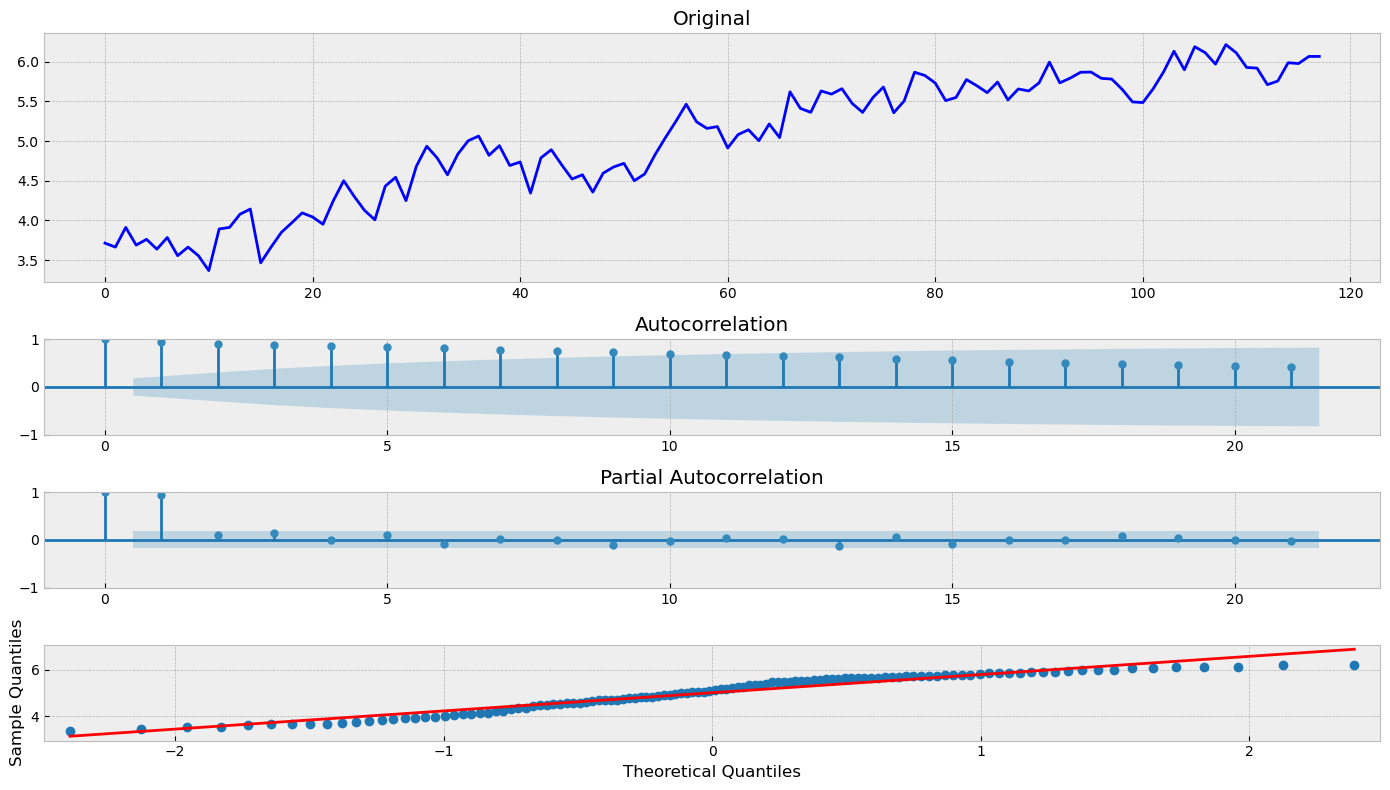

In [10]:
# Загрузка и преобразование данных
new_series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
#new_series = new_series[1:] - new_series[:-1] график уже стационарный по тестам, не вижу смысла использовать какие-то преобразования

# Визуализация новой временной серии
tsplot(new_series)

In [12]:
len(new_series)

118

#### От временного ряда перейдём к матрице траекторий:

In [25]:
L = 40 # The window length. По аналогии с занятием возьму 40 значений. Там количество точек было 200, у меня 118.
K = len(new_series) - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([new_series[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

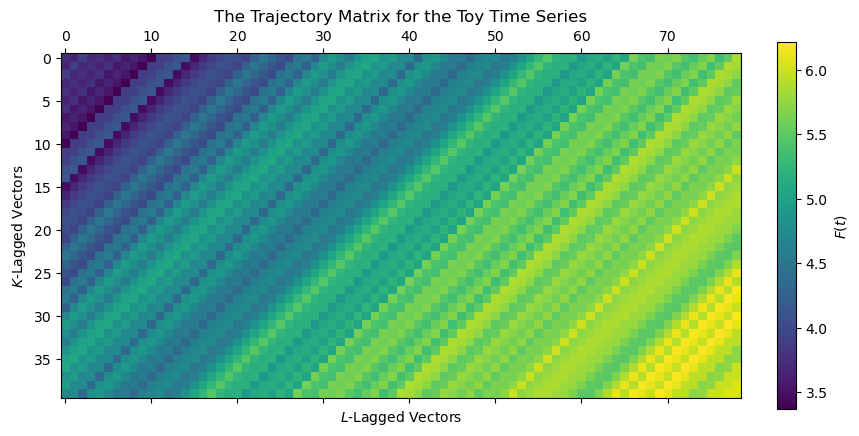

In [26]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

#### Разложение матрицы траекторий:
$$\mathbf{X} = \mathbf{U\Sigma V}^{\text{T}}$$
где:
* $\mathbf{U}$ - унитарная матрица $L \times L$, содержащая ортонормированное множество ***левых сингулярных векторов*** $\mathbf{X}$ в виде столбцов;
* $\mathbf{\Sigma}$ - прямоугольная диагональная матрица $L \times K$, содержащая $L$ ***сингулярные значения*** $\mathbf{X}$, упорядоченные от наибольшего к наименьшему; и
* $\mathbf{V}$ - это унитарная матрица $K \times K$, содержащая ортонормированное множество ***правых сингулярных векторов*** $\mathbf{X}$ в виде столбцов.

In [27]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

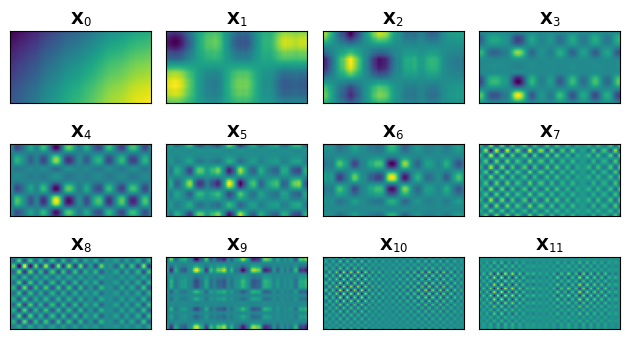

In [28]:
n = min(12, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Можно попробовать провести визуальный анализ. 

Нулевой график явно тренд.
Дальше, с первого по шестой, скорее всего, сезонность/цикличность. После шестого, скорее всего, начинается шум.

In [30]:
#1 график: относительный вклад в матрицу
#2 график: кумулятивная сумма (сумма предыдущих элементов до 100%)

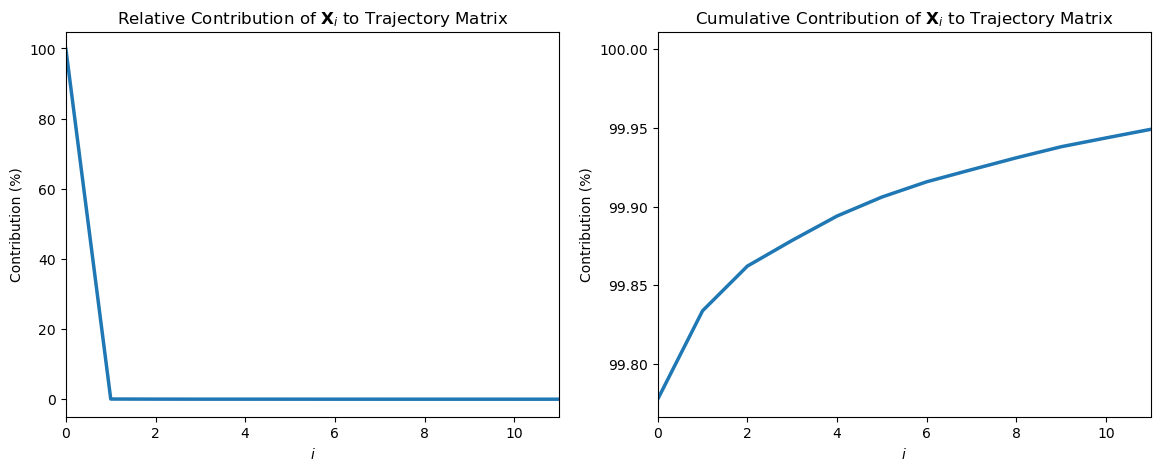

In [29]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

Получается, что нулевой компонент описывает практически весь временной ряд в данном случае.

#### Хейнкелизируем

In [31]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

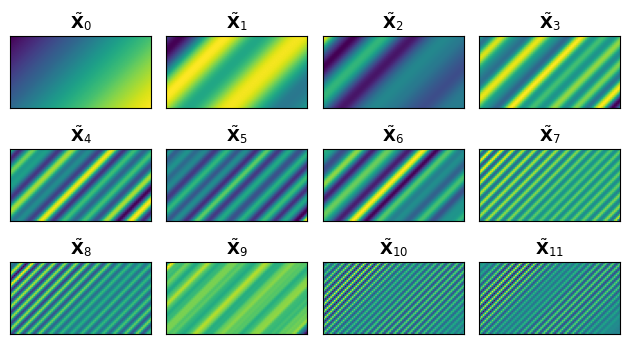

In [66]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

Тут уже гораздо лучше видны компоненты. И действительно, с седьмого графика шум, до седьмого разные компоненты сезонности, и нулевой график тренд

#### А теперь построим сам график и его компоненты:

In [40]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

In [41]:
from cycler import cycler

In [42]:
t = np.arange(0,len(new_series))

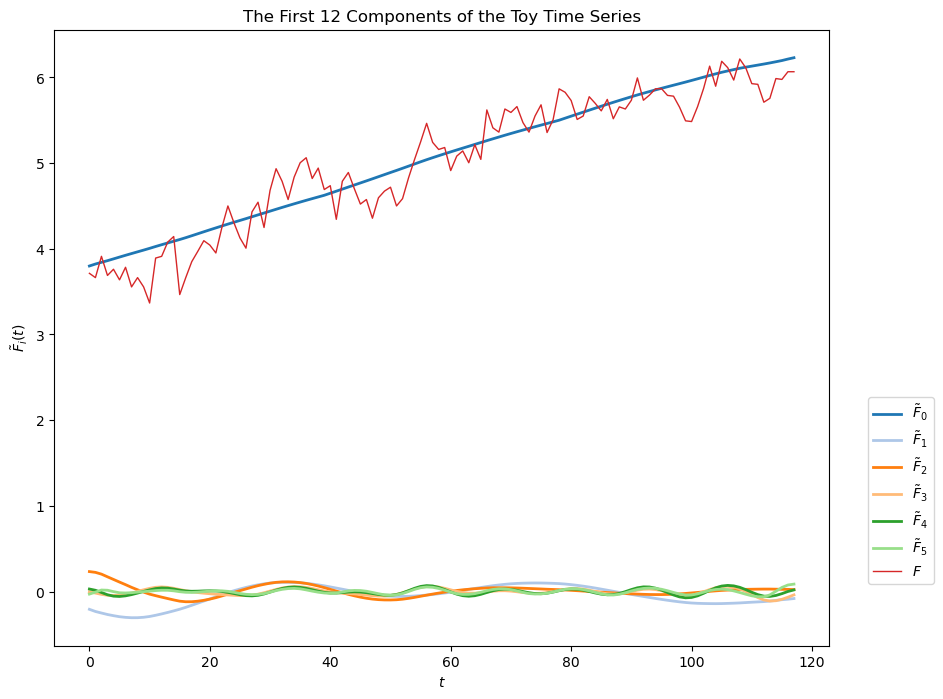

In [58]:
n = min(6,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
plt.figure(figsize=((10,8)))
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)


fig.axes.plot(t, new_series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

Отлично видно, что основное влияние на график оказывает именно тренд. Теперь попробуем сгруппировать. Отдельно построим тренд как самый важный компонент, отдельно сгруппирую всю сезонность, и отдельно шум.

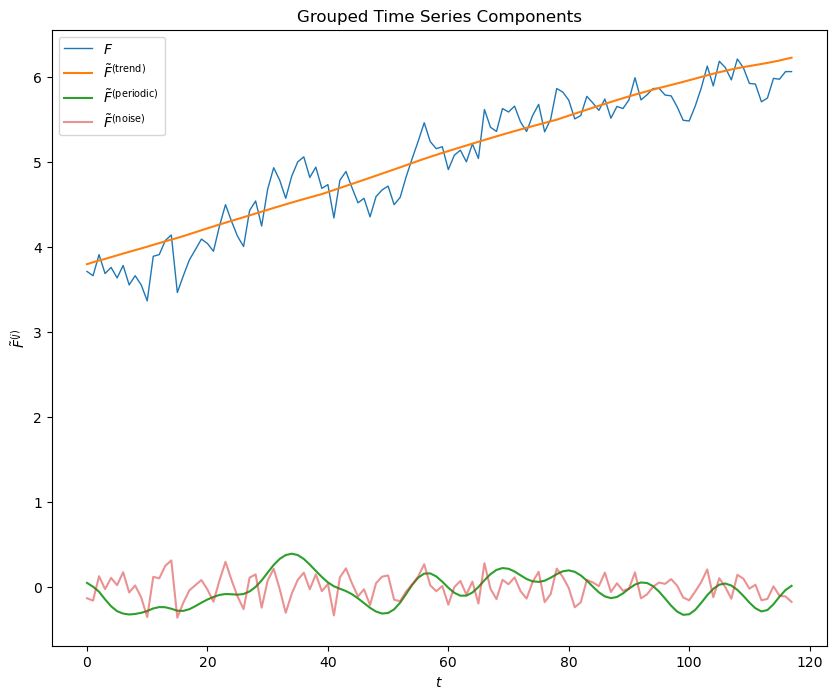

In [67]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0]].sum(axis=0))
F_periodic = X_to_TS(X_elem[[1,2,3,4,5,6]].sum(axis=0))
#F_periodic2 = X_to_TS(X_elem[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem[7:].sum(axis=0))
plt.figure(figsize=((10,8)))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t,new_series, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
#plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
#components = [("Trend", trend, F_trend), 
#             ("Periodic 1", periodic1, F_periodic1),
#              ("Periodic 2", periodic2, F_periodic2),
#              ("Noise", noise, F_noise)]

# Plot the separated components and original components together.
#fig = plt.figure()
#n=1
#for name, orig_comp, ssa_comp in components:
#    ax = fig.add_subplot(2,2,n)
#    ax.plot(t, orig_comp, linestyle="--", lw=2.5, alpha=0.7)
#    ax.plot(t, ssa_comp)
#    ax.set_title(name, fontsize=16)
#    ax.set_xticks([])
#    n += 1

#fig.tight_layout()

#### Вывод: 
Достаточно интересная тема, возникает желание поэксперементировать с разными длинами окна, посмотреть, на какие компоненты раскладываются сложные временные ряды. Ещё восхищает количество способов применения, одним инструментом можно многое сделать, и проанализовать, и сгладить, и очень наглядно продемонстрировать результаты анализа.